[INFO] loading images...
[INFO] compiling model...
[INFO] training head...
Epoch 1/80
28/28 [==============================] - 40s 1s/step - loss: 0.6306 - accuracy: 0.6728 - val_loss: 0.3374 - val_accuracy: 0.8941
Epoch 2/80
28/28 [==============================] - 34s 1s/step - loss: 0.3355 - accuracy: 0.8737 - val_loss: 0.2211 - val_accuracy: 0.9276
Epoch 3/80
28/28 [==============================] - 35s 1s/step - loss: 0.2437 - accuracy: 0.9116 - val_loss: 0.1669 - val_accuracy: 0.9638
Epoch 4/80
28/28 [==============================] - 33s 1s/step - loss: 0.2105 - accuracy: 0.9150 - val_loss: 0.1447 - val_accuracy: 0.9561
Epoch 5/80
28/28 [==============================] - 36s 1s/step - loss: 0.1973 - accuracy: 0.9265 - val_loss: 0.1303 - val_accuracy: 0.9561
Epoch 6/80
28/28 [==============================] - 31s 1s/step - loss: 0.1582 - accuracy: 0.9392 - val_loss: 0.1276 - val_accuracy: 0.9457
Epoch 7/80
28/28 [==============================] - 33s 1s/step - loss: 0.1401 - accu

28/28 [==============================] - 31s 1s/step - loss: 0.0374 - accuracy: 0.9885 - val_loss: 0.0702 - val_accuracy: 0.9716
Epoch 58/80
28/28 [==============================] - 32s 1s/step - loss: 0.0424 - accuracy: 0.9851 - val_loss: 0.0758 - val_accuracy: 0.9690
Epoch 59/80
28/28 [==============================] - 32s 1s/step - loss: 0.0403 - accuracy: 0.9897 - val_loss: 0.0797 - val_accuracy: 0.9716
Epoch 60/80
28/28 [==============================] - 33s 1s/step - loss: 0.0322 - accuracy: 0.9897 - val_loss: 0.0702 - val_accuracy: 0.9716
Epoch 61/80
28/28 [==============================] - 32s 1s/step - loss: 0.0319 - accuracy: 0.9877 - val_loss: 0.0862 - val_accuracy: 0.9690
Epoch 62/80
28/28 [==============================] - 33s 1s/step - loss: 0.0443 - accuracy: 0.9862 - val_loss: 0.0690 - val_accuracy: 0.9742
Epoch 63/80
28/28 [==============================] - 34s 1s/step - loss: 0.0343 - accuracy: 0.9885 - val_loss: 0.0713 - val_accuracy: 0.9716
Epoch 64/80
28/28 [======

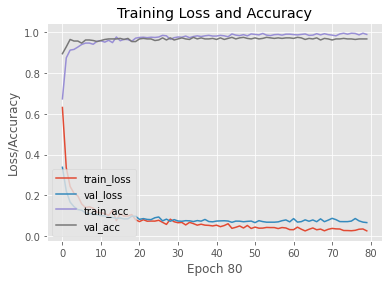

In [6]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import time

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 80
BS = 32

DIRECTORY = r"C:\Users\User\dataset"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.30, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False
       

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])



# train the head of the network
print("[INFO] training head...")
start = time.time()
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


print("Total time: ", time.time() - start, "seconds")
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_epoch80.model", save_format="h5")


# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch 80")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")